<a href="https://colab.research.google.com/github/millergw/cs181-s23-homeworks/blob/main/Case_Study_Out_of_Distribution_Detection_in_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case Study: Out of Distribution Detection in Classification

### CS181

#### Spring 2023

<img src="https://images2.imgbox.com/82/02/eGybE7NX_o.png" alt="image host"/>

In [ ]:
import numpy as np
import pandas as pd
import numpy
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.preprocessing import PolynomialFeatures
from pymc import Model
import pymc as pm
import matplotlib.pyplot as plt
import sys
%matplotlib inline

In [ ]:
def plot_decision_boundary(x, y, models, ax, poly_degree=1, test_points=None, shaded=True):
    '''
    plot_decision_boundary plots the training data and the decision boundary of the classifier.
    input:
       x - a numpy array of size N x 2, each row is a patient, each column is a biomarker
       y - a numpy array of length N, each entry is either 0 (no cancer) or 1 (cancerous)
       models - an array of classification models
       ax - axis to plot on
       poly_degree - the degree of polynomial features used to fit the model
       test_points - test data
       shaded - whether or not the two sides of the decision boundary are shaded
    returns: 
       ax - the axis with the scatter plot
    
    '''
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='red', label='class 1')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='blue', label='class 0')
    
    # Create mesh
    interval = np.arange(-6, 6, 0.1)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_degree > 1):
        polynomial_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
        xx = polynomial_features.fit_transform(xx)
    
    if len(models) > 1:
        alpha_line = 0.1
        linewidths=0.1
    else:
        alpha_line = 0.8
        linewidths=0.5
        
    i = 0
    
    for model in models:
        yy = model.predict(xx)  
        yy = yy.reshape((n, n))

        # Plot decision surface
        x1 = x1.reshape(n, n)
        x2 = x2.reshape(n, n)
        if shaded:
            ax.contourf(x1, x2, yy, alpha=0.1 * 1. / (i + 1)**2, cmap='bwr')
        ax.contour(x1, x2, yy, colors='black', linewidths=linewidths, alpha=alpha_line)
        
        i += 1
        
    if test_points is not None:
        for i in range(len(test_points)):
            pt = test_points[i]
            if i == 0:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
            else:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
        
    ax.set_xlim((-5.5, 5.5))
    ax.set_ylim((-5.5, 5.5))
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.legend(loc='best')
    return ax

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class Bayesian_logistic_regression:
    def __init__(self, intercept, slopes):
        self.intercept = intercept
        self.slopes = slopes

    def predict(self, x):
        y = sigmoid(x.dot(self.slopes) + self.intercept)
        return (y > 0.5).astype(np.int_)

    def predict_proba(self, x):
        return sigmoid(x.dot(self.slopes) + self.intercept)

## Problem Description: 
In this case study, we evaluate the usefulness of the predictive uncertainties Logistic Regression models and Bayesian Logistic models for test data that are dissimilar to our training data. These test data points are called ***out of distribution (OOD) points***. Just as in Homework #2, we want the predictive uncertainties from our models to help us distinguish ***in-distribution*** test data (test data that are similar to data on which we trained our model) and OOD test data. Again, in many safety-critical applications of ML, we want human-experts to override model decisions if the model is operating on extremely unfamiliar data.

### Part I: Classifying Out of Distribution Handwritten Digits

In class, we have interpreted the output of a Logistic Regression model - the classification probability - as an indicator of the confidence of the model when it is classifying a specific data point (e.g. when the probability is close to 0.5, we say that the model is not confident in classifying the data point as class 1 or 0). 

In this case study, we build a Logistic Regression model to distinguish between digital images of handwritten digits (this is the MNIST dataset):

` LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)`

For simplicity, we only look at images of digits: 1 and 6. 

In this dataset, the classes are balanced (we take 600 images of each digit). Based on the accuracy of your trained classifier, based on this, we will decide whether or not this is a good model.

Next, we will consider a set of six test images: three of which are similar to our training images and three that are quite different from our training images,
`test_point_1`, ..., `test_point_6`.
We will compute the classification probabiliy for each image under our trained model and interpreting these probabilities as uncertainty, i.e. model confidence. 

In [ ]:
 # Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [ ]:
X = X.values
y = y.values

# Pick out two classes of digits: 1, 6 and take a subset of samples
X_subset = X[((y == '1') | (y == '6'))][0:600]
y_subset = y[((y == '1') | (y == '6'))][0:600]

# Encode the label '1' with y=1, and the label '6' with y=0
y_subset[y_subset == '1'] = '1'
y_subset[y_subset == '6'] = '0'
y_subset = y_subset.astype(int)

In [ ]:
# Randomize our data
random_state = check_random_state(0)
permutation = random_state.permutation(X_subset.shape[0])
X_subset = X_subset[permutation]
y_subset = y_subset[permutation]
X_subset = X_subset.reshape((X_subset.shape[0], -1))

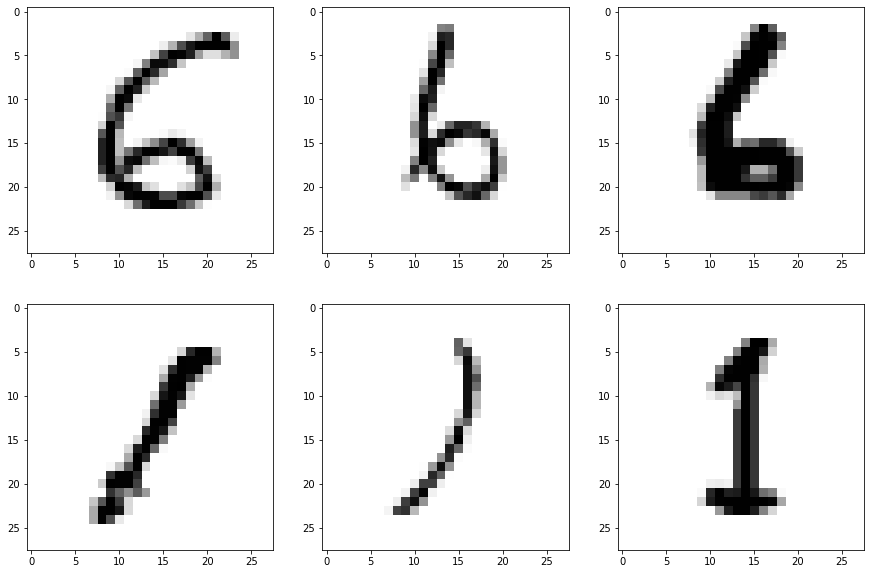

In [ ]:
# Visualize some samples from the training dataset
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(3):
    ax[0, i].imshow(X_subset[y_subset == 0][i].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax[1, i].imshow(X_subset[y_subset == 1][i].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

In [ ]:
# Test images for evaluating your classifier
test_point_1 = X_subset[y_subset == 0][0]
test_point_2 = X_subset[y_subset == 1][0]
test_point_3 = X[y=='3'][0]
test_point_4 = np.random.normal(200, 10, size=(28 * 28, ))
test_point_5 = test_point_2 + np.random.normal(300, 10, size=(28 * 28, )) - test_point_1
test_point_6 = test_point_2 + test_point_1 + np.random.normal(100, 10, size=(28 * 28, ))

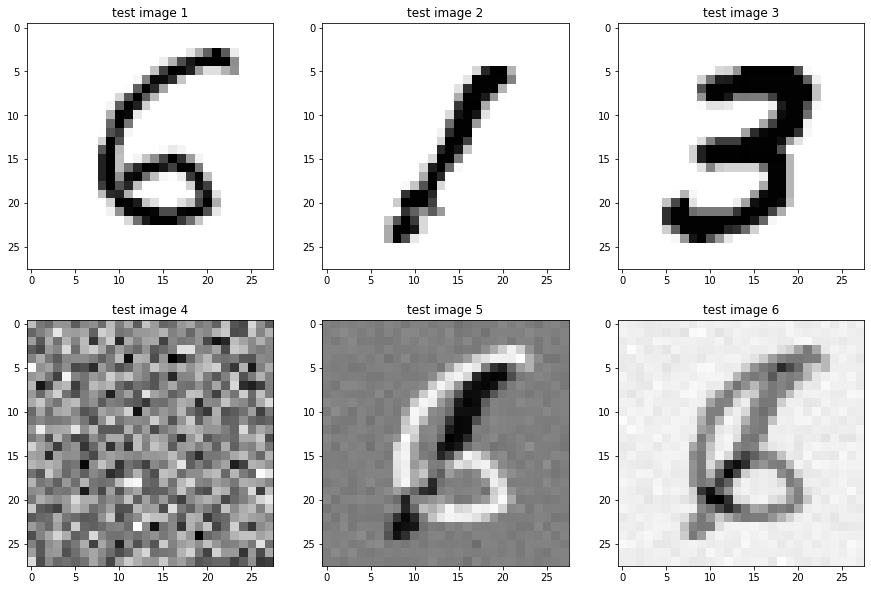

In [ ]:
# Visualize some samples from the test dataset
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].imshow(test_point_1.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[0, 0].set_title('test image 1')
ax[0, 1].imshow(test_point_2.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[0, 1].set_title('test image 2')
ax[0, 2].imshow(test_point_3.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[0, 2].set_title('test image 3')
ax[1, 0].imshow(test_point_4.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[1, 0].set_title('test image 4')
ax[1, 1].imshow(test_point_5.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[1, 1].set_title('test image 5')
ax[1, 2].imshow(test_point_6.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[1, 2].set_title('test image 6')
plt.show()

We first fit a logistic regression model to our training data.

In [ ]:
# Fit a logistic regression model on training data
logistic = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
logistic.fit(X_subset, y_subset)

LogisticRegression(solver='saga', tol=0.1)

This is a case where we can't visualize our actual dataset and so we can't visualize the decision boundary. So we compute the accuracy of our trained classifier (note that since the classes are balanced, accuracy is a good metric for model performance).

In [ ]:
print('Accuracy of the logistic regression model: ', logistic.score(X_subset, y_subset))

Accuracy of the logistic regression model:  0.9933333333333333


We see that our logistic regression model is highly accurate, so even though we can't visualize the decision boundary, we can image that the images of `1` and the images of `6` are probably easily separated with a line (linear separable). So this is good right?

Well, the problem is that we don't always use models under the same conditions under which they are built - specifically, even though the model was trained on `1`'s and `6`'s, when the model is being deployed it might be asked to classify images of `2`'s or `3`'s or images of other objects all together (i.e. out of distribution data or data with covariate shift)! So what happens when we show OOD images to our classifier? 

Let's evaluate our classifier's output (the classification probability) at our OOD points.

In [ ]:
# Compute the classification probabilities for the test images
data = np.vstack((logistic.predict_proba(test_point_1.reshape((1, -1))), 
                  logistic.predict_proba(test_point_2.reshape((1, -1))),
                  logistic.predict_proba(test_point_3.reshape((1, -1))),
                  logistic.predict_proba(test_point_4.reshape((1, -1))),
                  logistic.predict_proba(test_point_5.reshape((1, -1))),
                  logistic.predict_proba(test_point_6.reshape((1, -1)))))

pd.DataFrame(data, columns=['Probability of Digit 6', 'Probability of Digit 1'], 
             index=['test point 1', 'test point 2', 'test point 3', 'test point 4', 'test point 5', 'test point 6'])

,Probability of Digit 6,Probability of Digit 1
test point 1,0.997228,0.002772
test point 2,0.004823,0.995177
test point 3,0.485970,0.514030
test point 4,0.991779,0.008221
test point 5,0.015106,0.984894
test point 6,0.949424,0.050576


We see that our logistic regression model classifies test point 1 as a `6` with nearly 100% probability, this makes sense since the image looks very much like a typical `6`. The model classifies the second test point as a `1` with nearly 100% probability (i.e. the classification probability for a `6` is nearly 0 percent), this also makes sense. Test point 3, however, is an image of a `3`, which the classifier confidently classifies as a digit `1`. Test point 4 is an image of random Gaussian noise, which the classifier classifies as a digit `6` with nearly 100% probability. Test point 5 is a superposition of a `1` and a `6`, with the `6` rendered in negative contrast, this image is classified as a `1` with near 100% probability. Finally, test point 6 is a superposition of a `1` and a `6`, with both images in positive contrast, and the classifier classifies this as a `6` with near 100% probability. 

We see that in cases of test points 3-6 the classifier is making not only incorrect, but nonsensical classifications and is doing so with near perfect confidence. This type of errors are especially insidious! Why? Because:
1. the model has extremely good performance on data that looks like training data, digits `1` and `6`, so engineers or practitioners may be more inclined to accept the model's decisions.
2. in a typical application, an engineer or a practitioner might check test points for which the classification probability is close to 50%, but will interpret a classification of 100% and 0% as more likely to be correct (because the model is more confident).

You might say that this problem is simple to solve: if the model is trained on `1`'s and `6`'s, then let people know that images of `3`'s, `4`'s and other objects are out-of-distribution and should not be fed into the model! 

But can you always know what is out-of-distribution? That is, let say that you trained a classifier to distinguish people from inanimate objects in images and your training data consisting of millions of scraped photographs does not contain enough images of children (i.e. children are OOD). Then it is likely that when shown an image of a child your classifier will confidently classify the child as an inanimate object with perfect confidence. Unlike in the case of training a classifier only on digits `1` and `6`, here, you only know that your dataset contains images of people and so it's not obvious that images of a subgroup of people would be OOD - how on earth could you have known that your training data did not contain enough examples of children (is it practical to look at every image in your dataset)? If you think this scenario is purely hypothetical, it is not, for example see the controversy that followed Google's introduction of an automatic image annotation feature (https://www.bbc.com/news/technology-33347866).

But why would a classifier be so confident when it's so wrong on OOD points? We explore a possible reason in the following exercises.

---

### Part II: Understanding Failure Modes on Out of Distribution Data

**Exercise 1: (The Need for Useful Uncertainties in Classification)** Explain why OOD detection may be crucial for classifiers deployed in risk-adverse applications. Be concrete: choose a real-life domain application, identify the real-life consequences of an incorrect classification, explain *exactly* how OOD detection can help mitigate the risk of an incorrect classification. Feel free to use the following list of articles to help construct your answer.

**Reference:**
1. [Facial Recognition Is Accurate, if You’re a White Guy](https://www.nytimes.com/2018/02/09/technology/facial-recognition-race-artificial-intelligence.html)
2. [IBM Builds a More Diverse Million-Face Dataset to Help Reduce Bias in AI](https://techcrunch.com/2019/01/29/ibm-builds-a-more-diverse-million-face-dataset-to-help-reduce-bias-in-ai/)
3. [Wrongfully Accused by an Algorithm](https://www.nytimes.com/2020/06/24/technology/facial-recognition-arrest.html)
4. [Gender imbalance in medical imaging datasets produces biased classifiers for computer-aided diagnosis](https://www.pnas.org/content/pnas/early/2020/05/19/1919012117.full.pdf)

**Exercise 2: (Classifying OOD Data for a Toy Dataset)** The problem with logistic regression on MNIST is that we can't visualize the data or the decision boundary and so it is hard to conjecture wherein lies the source of the over-confidence of the model. In this problem, we consider a simple toy dataset with test points that are in-distribution and out-of-distribution and we will try to recreate the problems we observed on MNIST.

In this Exercise, build a Logistic Regression model to distinguish between two classes in our toy classification dataset:

` LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)` 

In this dataset, the classes are balanced (we have 100 points in each class). Report the accuracy of your trained classifier, based on this, decide whether or not this is a good model.

Next, for the predefined set of test points,
`test_points`,
report the classification probabiliy for each test point under your trained model. Interpreting these probabilities as uncertainty, i.e. model confidence, do these predictive uncertainties make sense? **Hint:** compare the predictive uncertainties to the visualizations of these test points, identify which of these test points are in-distribution and which ones are OOD.

Relate your analysis of the behaviour of Logistic Regression on this toy dataset to its performance on MNIST. Can you come up with some hypotheses for exactly when the classification probability indicates an inappropriate amount of certainty when predicting on test points?

In [ ]:
# Generate a toy dataset for classification
samples = 100
class_0 = np.random.multivariate_normal([-1, -1], 0.5 * np.eye(2), samples)
class_1 = np.random.multivariate_normal([1, 1], 0.5 * np.eye(2), samples)
x = np.vstack((class_0, class_1))
y = np.array([0] * 100 + [1] * 100)

In [ ]:
# Define test data points
test_points = [(-5, -5), (-5, 3.5), (5, 5), (5, -3.5), (-1, 1), (-1, -1.5), (1, 1.5)]

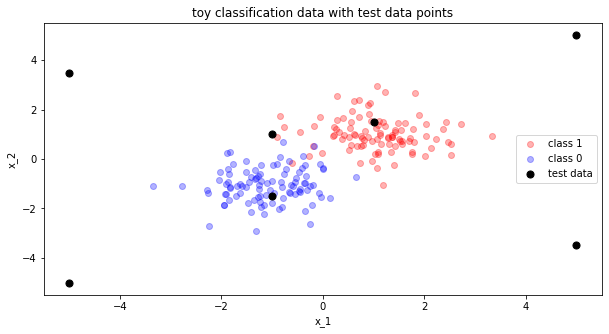

In [ ]:
# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(test_points)):
    pt = test_points[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')
plt.show()

Let's fit a logistic regression to our toy dataset.

In [ ]:
# Fit a logistic regression model on the toy training data
logistic = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
logistic.fit(x, y)

LogisticRegression(solver='saga', tol=0.1)

Again, we evaluate the accuracy of our model (note that since the classes are balanced, the accuracy is a good indicator of the model's performance).

In [ ]:
print('Accuracy of the logistic regression model: ', logistic.score(x, y))

Accuracy of the logistic regression model:  0.98


Unlike before, this time we can actually visualize the decision boundary of the learned model! Both the decision boundary and the accuracy indicate that the learned logistic regression model fits the data well!

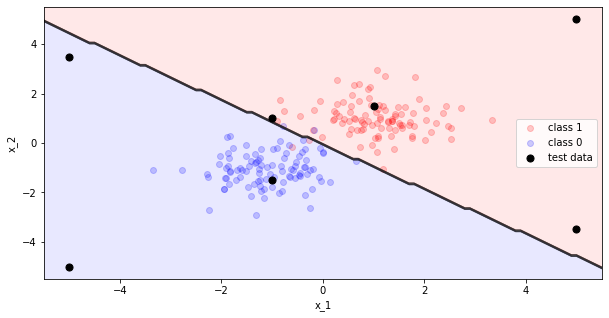

In [ ]:
# Plot the decision boundary for the learned model
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plot_decision_boundary(x, y, [logistic], ax, poly_degree=1, test_points=test_points, shaded=True)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()

Now let's see what are the classification probabilies for each of our chosen test points!

In [ ]:
# Compute the classification probabilities of the test points
data = np.vstack([logistic.predict_proba(np.array(pt).reshape((1, -1))) for pt in test_points])
pd.DataFrame(data, columns=['Probability of Class 0', 'Probability of Class 1'], 
             index=[str(pt) for pt in test_points])

,Probability of Class 0,Probability of Class 1
"(-5, -5)",1.000000e+00,3.604729e-11
"(-5, 3.5)",9.198626e-01,8.013736e-02
"(5, 5)",2.576006e-11,1.000000e+00
"(5, -3.5)",5.860793e-02,9.413921e-01
"(-1, 1)",3.991853e-01,6.008147e-01
"(-1, -1.5)",9.973899e-01,2.610085e-03
"(1, 1.5)",1.866604e-03,9.981334e-01


**Exercise 3: (Classifying OOD Data for a Toy Dataset with Bayesian Logistic Regression)** 
In Exercise 2, we examined one source of uncertainty from a logistic model: the classification probability. There is another source of uncertainty: uncertainty over the model itself (which decision boundaries can fit the dataset). We can this ***epistemic uncertainty***.

We will use a `python` package to sample from the posterior of the following Bayesian Logistic Regression model for our toy dataset:

\begin{align}
w_i &\sim \mathcal{N}(0, 10)\\
Y^{(n)} &\sim Ber(\text{sigm}(w_2 X_1^{(n)} + w_1 X_2^{(n)} + w_0))
\end{align}

where $w_i$, $Y^{(n)}$, $X_i^{(n)}$ are real scalar valued random variables, and where the data consists of the observations $(x_1^{(n)}, x_2^{(n)}, y^{(n)})$ in our toy dataset $\mathcal{D}$.

We will visualize the decision boundaries corresponding to the posterior samples from our Bayesian Logistic Regression model. 

What do the distribution of decision boundaries tell you about the model's predictive uncertainties for each of the test points (particularly the OOD points)?

In [ ]:
# Sample from the posterior of the Bayesian logistic regression model
var = 10.
with pm.Model() as bayesian_model:
    #define priors
    slopes = pm.Normal('slopes', mu=0, tau=1./var, shape=x.shape[1])
    intercept = pm.Normal('intercept', mu=0, tau=1./var)
    
    #define linear model, using marital status as a covariate
    mu = intercept + pm.math.dot(x, slopes) 
    #transform linear model into a probability
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))

    #define binomial likelihood
    y_observed = pm.Bernoulli('y_obs',  p=theta, observed=y)

    trace = pm.sample(4000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slopes]


Sampling 2 chains for 2_000 tune and 4_000 draw iterations (4_000 + 8_000 draws total) took 54 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.



For each sample in the posterior of our Bayesian logistic regression model, we create a wrapper model that as the same API as `sklearn`'s logistic regression model, so that we can feed it into the `plot_decision_boundary` function.

In [ ]:
# Build a model for each sample in the posterior
thinned_trace = trace[::10]
posterior_samples_index = np.random.choice(np.arange(len(thinned_trace)), size=100)
models = []

for index in posterior_samples_index:
    sample = thinned_trace[index]
    model = Bayesian_logistic_regression(sample['intercept'], sample['slopes'])
    models.append(model)

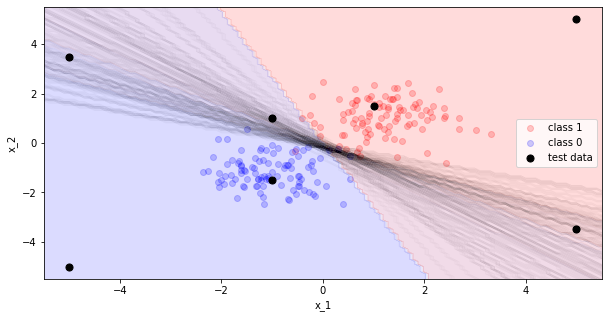

In [ ]:
# Visualize the decision boundaries corresponding to the samples in the posterior
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plot_decision_boundary(x, y, models, ax, test_points=test_points, poly_degree=1)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()

**Exercise 4: (Classifying OOD Data for a Toy Dataset with Bayesian Non-linear Logistic Regression)** 
Just as we can cast Bayesian Non-linear Regression as a non-linear transformation of the data followed by Bayesian Linear Regression, we can perform Bayesian Logistic Regression with non-linear decision boundaries by first applying a non-linear feature map to the data and then fitting a Bayesian Logistic Regression model on the features.

We perform Bayesian Logistic Regression using a degree 2 polynomial feature map, $\phi$, on the toy dataset. We sample from the posterior of the following Bayesian Logistic Regression model for our toy dataset:

\begin{align}
\mathbf{w} &\sim \mathcal{N}(0, 10\, \mathbf{I})\\
Y^{(n)} &\sim Ber(\text{sigm}(\mathbf{w}^\top \phi(\mathbf{X}^{(n)}) ))
\end{align}

We then visualize the decision boundaries corresponding to the samples in the posterior. 

Are the epistemic uncertainties of this Bayesian model able to distinguish in-distribution test points from OOD ones? Relate the amount of epistemic uncertainty at a particular data point to the decision boundaries in the posterior $p(\mathbf{w} | \mathcal{D}))$. Using this geometric relationship, explain whether or not the epistemic uncertainties of our Bayesian Logistic Regression model is capable of distinguishing **all** possible OOD points.

In [ ]:
# Augment the training data with degree 2 polynomial features
poly = PolynomialFeatures(2, include_bias=False)
x_poly = poly.fit_transform(x)

In [ ]:
# Sample from the posterior of the Bayesian logistic regression model with degree 2 features
var = 10.
with pm.Model() as bayesian_model:
    #define priors
    slopes = pm.Normal('slopes', mu=0, tau=1./var, shape=x_poly.shape[1])
    intercept = pm.Normal('intercept', mu=0, tau=1./var)
    
    #define linear model, using marital status as a covariate
    mu = intercept + pm.math.dot(x_poly, slopes) 
    #transform linear model into a probability
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))

    #define binomial likelihood
    y_observed = pm.Bernoulli('y_obs',  p=theta, observed=y)

    trace = pm.sample(4000, tune=5000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, slopes]


Sampling 2 chains for 5_000 tune and 4_000 draw iterations (10_000 + 8_000 draws total) took 103 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
# Build a model for each sample in the posterior
thinned_trace = trace[::10]
posterior_samples_index = np.random.choice(np.arange(len(thinned_trace)), size=100)
models = []

for index in posterior_samples_index:
    sample = thinned_trace[index]
    model = Bayesian_logistic_regression(sample['intercept'], sample['slopes'])
    models.append(model)

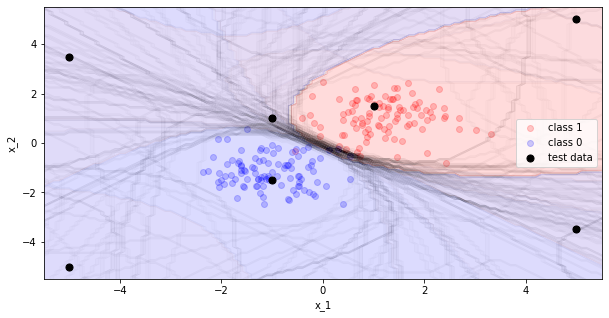

In [ ]:
# Visualize the decision boundaries corresponding to the samples in the posterior
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plot_decision_boundary(x, y, models, ax, test_points=test_points, poly_degree=2)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()

**Exercise 5: (Classifying OOD Data for a Toy Dataset with Bootstrap Non-linear Logistic Regression)** As an alternative to Bayesian Logistic regression, we can obtain uncertainty over decision boundaries by bootstrapping. We obtain 100 bootstrap Logistic Regression models:
`LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)`.

We then visualize the decision boundaries corresponding to the samples in the bootstrap ensemble. 

Are the epistemic uncertainties of this ensemble able to distinguish in-distribution test points from OOD ones? Relate the amount of epistemic uncertainty at a particular data point to the decision boundaries of the models in the ensemble. Using this geometric relationship, explain whether or not the epistemic uncertainties of our bootstrap ensemble is capable of distinguishing **all** possible OOD points.

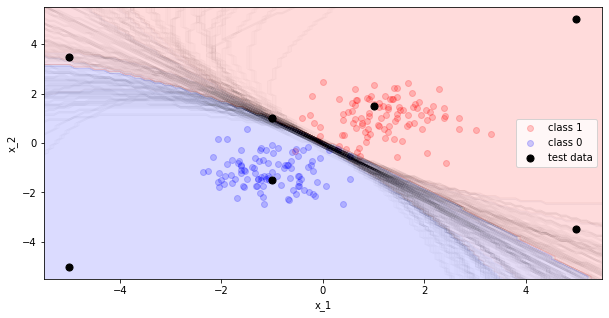

In [ ]:
# Visualize the decision boundaries of the bootstrap models
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
models = []

for i in range(100):
    bootstrap_indices = np.random.choice(np.arange(0, len(y)), size=len(y))
    X_bootstrap = x_poly[bootstrap_indices]
    y_bootstrap = y[bootstrap_indices]
    logistic = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
    logistic.fit(X_bootstrap, y_bootstrap)
    models.append(logistic)

ax = plot_decision_boundary(x, y, models, ax, test_points=test_points, poly_degree=2)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()

### Part III: What Uncertainties Do We Need in Classification?

**Exercise 6: (Comparing Bayesian and Frequnetist Epistemic Uncertainties)** In the in-class exercise from Tuesday February 21st, we saw that the epistemic uncertainties of frequentist and Bayesian uncertainties can be desirable or undesirable depending on the number of observations and the choices of hyperparameters (e.g. polynomial degree, variance of the prior in the Bayesian model, regularization strength of the models in the ensemble). 

For Bayesian and frequentist ensembles of classifiers, based on empirical results above, conjecture which factors affect the quality of epistemic uncertainties of Bayesian and bootstrap ensemble classifiers, respectively. Support your answer with what we know about the properties of Logistic Regression models.

In order to obtain epistemic uncertainties that can distinguish in-distribution and OOD points, what settings of hyperparameters do we need for Bayesian and bootstrap ensemble classifiers, respectively?

**Exercise 7: (Is OOD Detection Enough for Risk Adverse Applications?)** In the risk-adverse real-life application you identified in Exercise 1, is accurate OOD detection enough to mitigate unwanted outcomes of deploying our model? That is, when classifiers are used in real-life applications where incorrect predictions can have disasterous consequence, what specific failure modes can these models experience? Are all of these failure modes addressed by proper detection of OOD inputs?

For more reasons why your model might be disaster, see [Why Is My Classifier Discriminatory?](https://arxiv.org/pdf/1805.12002.pdf)